# Prediction Intervals for Deep Learning Neural Networks

by Jason Brownlee on February 22, 2021 in Deep Learning

https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

Oct 9, 2021

Not a regression but a point prediction with error bar???


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import scipy
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

tfd = tfp.distributions

In [43]:
xname="sm_0.67"; yname="halo_mass"
xname="stellarmass"; yname="halo_mass"; x2name="central_sm"

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x=cluster_data[xname]; 
y=cluster_data[yname];
x2=cluster_data[x2name]

from sklearn.model_selection import train_test_split
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.67)
print("train:  ",X_train.shape, y_train.shape," test:  ",  X_test.shape, y_test.shape)

#unit_df =pd.DataFrame(data={xname:X_train,xname+"-test":X_test, yname:y_train, yname+"-test":y_test}) 
unit_df =pd.DataFrame(data={xname:X_train, yname:y_train,})

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(unit_df)
print("X_t shape",X_t.shape)

# Remove outliers.
detector = IsolationForest(n_estimators=1000,  contamination=0.15, random_state=0)
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
unit_df =pd.DataFrame(data={xname:X_t[:,0], yname:X_t[:,1]})

X_t = scaler.inverse_transform(unit_df)
inv_df=pd.DataFrame(data={xname:X_t[:,0], yname:X_t[:,1]})
xc=X_t[:,0]
yc=X_t[:,1]

train:   (192,) (192,)  test:   (95,) (95,)
X_t shape (192, 2)


Next, we can define, train and evaluate a Multilayer Perceptron (MLP) model on the dataset.

We will define a simple model with two hidden layers and an output layer that predicts a numeric value. We will use the ReLU activation function and “he” weight initialization, which are a good practice.

The number of nodes in each hidden layer was chosen after a little trial and error.

In [46]:
# define neural network model
features = 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, kernel_initializer='he_normal', activation='relu', input_dim=features))
model.add(tf.keras.layers.Dense(5, kernel_initializer='he_normal', activation='relu'))
model.add(tf.keras.layers.Dense(1))

We will use the efficient Adam version of stochastic gradient descent with close to default learning rate and momentum values and fit the model using the mean squared error (MSE) loss function, a standard for regression predictive modeling problems.

In [47]:
# compile the model and specify loss and optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
model.compile(optimizer=opt, loss='mse')

The model will then be fit for 300 epochs with a batch size of 16 samples. This configuration was chosen after a little trial and error.

In [52]:
# fit the model on the training dataset
model.fit(X_train, y_train, verbose=2, epochs=300, batch_size=64)

Epoch 1/300
3/3 - 0s - loss: 0.0603
Epoch 2/300
3/3 - 0s - loss: 0.0501
Epoch 3/300
3/3 - 0s - loss: 0.0529
Epoch 4/300
3/3 - 0s - loss: 0.0350
Epoch 5/300
3/3 - 0s - loss: 0.0385
Epoch 6/300
3/3 - 0s - loss: 0.0325
Epoch 7/300
3/3 - 0s - loss: 0.0267
Epoch 8/300
3/3 - 0s - loss: 0.0236
Epoch 9/300
3/3 - 0s - loss: 0.0246
Epoch 10/300
3/3 - 0s - loss: 0.0241
Epoch 11/300
3/3 - 0s - loss: 0.0311
Epoch 12/300
3/3 - 0s - loss: 0.0270
Epoch 13/300
3/3 - 0s - loss: 0.0234
Epoch 14/300
3/3 - 0s - loss: 0.0320
Epoch 15/300
3/3 - 0s - loss: 0.0265
Epoch 16/300
3/3 - 0s - loss: 0.0263
Epoch 17/300
3/3 - 0s - loss: 0.0239
Epoch 18/300
3/3 - 0s - loss: 0.0254
Epoch 19/300
3/3 - 0s - loss: 0.0323
Epoch 20/300
3/3 - 0s - loss: 0.0273
Epoch 21/300
3/3 - 0s - loss: 0.0232
Epoch 22/300
3/3 - 0s - loss: 0.0238
Epoch 23/300
3/3 - 0s - loss: 0.0267
Epoch 24/300
3/3 - 0s - loss: 0.0355
Epoch 25/300
3/3 - 0s - loss: 0.0373
Epoch 26/300
3/3 - 0s - loss: 0.0364
Epoch 27/300
3/3 - 0s - loss: 0.0288
Epoch 28/3

Finally, the model can be used to make predictions on the test dataset and we can evaluate the predictions by comparing them to the expected values in the test set and calculate the mean absolute error (MAE), a useful measure of model performance.

In [53]:
# make predictions on the test set
yhat = model.predict(X_test, verbose=0)
yhat=yhat[:,0]
# calculate the average error in the predictions
mae = tf.keras.losses.mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

MAE: 0.167


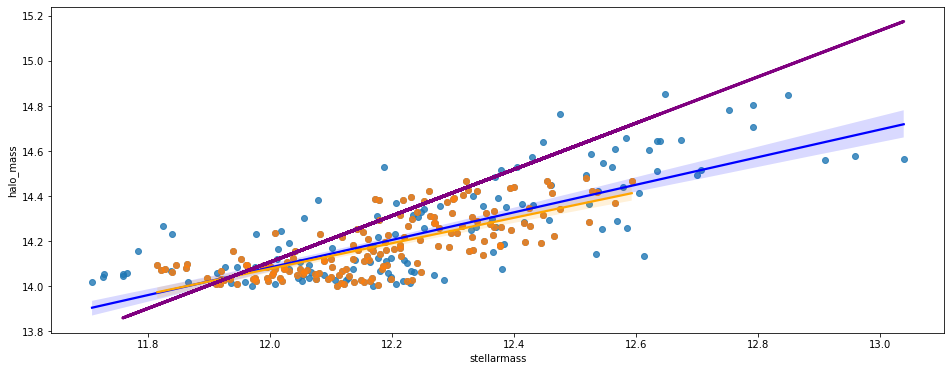

In [54]:
sns.regplot(x=xname,y=yname, data=cluster_data, line_kws={"color": "blue"})
sns.regplot(x=xname,y=yname, data=inv_df, line_kws={"color": "orange"})
plt.plot(X_test, yhat,'purple', label='mean', linewidth=3);


## Neural Network Prediction Interval

In this section, we will develop a prediction interval using the regression problem and model developed in the previous section.

Calculating prediction intervals for nonlinear regression algorithms like neural networks is challenging compared to linear methods like linear regression where the prediction interval calculation is trivial. There is no standard technique.

There are many ways to calculate an effective prediction interval for neural network models. I recommend some of the papers listed in the “further reading” section to learn more.

In this tutorial, we will use a very simple approach that has plenty of room for extension. I refer to it as “quick and dirty” because it is fast and easy to calculate, but is limited.

It involves fitting multiple final models (e.g. 10 to 30). The distribution of the point predictions from ensemble members is then used to calculate both a point prediction and a prediction interval.

For example, a point prediction can be taken as the mean of the point predictions from ensemble members, and a 95% prediction interval can be taken as 1.96 standard deviations from the mean.

This is a simple Gaussian prediction interval, although alternatives could be used, such as the min and max of the point predictions. Alternatively, the bootstrap method could be used to train each ensemble member on a different bootstrap sample and the 2.5th and 97.5th percentiles of the point predictions can be used as prediction intervals.

For more on the bootstrap method, see the tutorial:A Gentle Introduction to the Bootstrap Method

These extensions are left as exercises; we will stick with the simple Gaussian prediction interval.


Let’s assume that the training dataset, defined in the previous section, is the entire dataset and we are training a final model or models on this entire dataset. We can then make predictions with prediction intervals on the test set and evaluate how effective the interval might be in the future.

We can simplify the code by dividing the elements developed in the previous section into functions.

In [64]:

# define and fit the model
def fit_model(X_train, y_train):
	# define neural network model
	features = 1; #X_train.shape[1]
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(20, kernel_initializer='he_normal', activation='relu', input_dim=features))
	model.add(tf.keras.layers.Dense(5, kernel_initializer='he_normal', activation='relu'))
	model.add(tf.keras.layers.Dense(1))
	# compile the model and specify loss and optimizer
	opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
	model.compile(optimizer=opt, loss='mse')
	# fit the model on the training dataset
	model.fit(X_train, y_train, verbose=0, epochs=300, batch_size=16)
	return model

We require multiple models to make point predictions that will define a distribution of point predictions from which we can estimate the interval.

As such, we will need to fit multiple models on the training dataset. Each model must be different so that it makes different predictions. This can be achieved given the stochastic nature of training MLP models, given the random initial weights, and given the use of the stochastic gradient descent optimization algorithm.

The more models, the better the point predictions will estimate the capability of the model. I would recommend at least 10 models, and perhaps not much benefit beyond 30 models.

The function below fits an ensemble of models and stores them in a list that is returned.

For interest, each fit model is also evaluated on the test set which is reported after each model is fit. We would expect that each model will have a slightly different estimated performance on the hold-out test set and the reported scores will help us confirm this expectation.

In [78]:
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        # define and fit the model on the training set
        model = fit_model(X_train, y_train)
        # evaluate model on the test set
        yhat = model.predict(X_test, verbose=0)
        mae = tf.keras.losses.mean_absolute_error(y_test, yhat)
        print(mae.shape)
        #print('>%d, MAE: %.3f' % (i+1, np.squeeze(mae)))
        # store the model
        ensemble.append(model)
    return ensemble

Finally, we can use the trained ensemble of models to make point predictions, which can be summarized into a prediction interval.

The function below implements this. First, each model makes a point prediction on the input data, then the 95% prediction interval is calculated and the lower, mean, and upper values of the interval are returned.

The function is designed to take a single row as input, but could easily be adapted for multiple rows.

In [85]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
	# make predictions
	yhat = [model.predict(X, verbose=0) for model in ensemble]
	yhat = np.asarray(yhat)
	# calculate 95% gaussian prediction interval
	interval = 1.96 * yhat.std()
	lower, upper = yhat.mean() - interval, yhat.mean() + interval
	return lower, yhat.mean(), upper

In [80]:
# fit ensemble
n_members = 30
ensemble = fit_ensemble(n_members, X_train, X_test, y_train, y_test)

(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)
(95,)


We can then use a single row of data from the test set and make a prediction with a prediction interval, the results of which are then reported.

We also report the expected value which we would expect would be covered by the prediction interval (perhaps close to 95% of the time; this is not entirely accurate, but is a rough approximation).

In [86]:
# make predictions with prediction interval
#newX = np.asarray([X_test[0, :]])
newX=X_test
lower, mean, upper = predict_with_pi(ensemble, newX)
print('Point prediction: %.3f' % mean)
print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
print('True value: %.3f' % y_test[0])

Point prediction: 14.172
95% prediction interval: [13.732, 14.613]
True value: 14.658
